Dollar neutrality: 

Beta neutrality: 

x=0 (and sector/style neutrality)

Position bounds by liquidity / borrow

Turnover constraints

Gross exposure cap




https://github.com/alpacahq/Momentum-Trading-Example/blob/master/algo.py
https://github.com/kieranjwood/trading-momentum-transformer
https://github.com/kieranjwood/slow-momentum-fast-reversion
https://github.com/pio-ne-er/Polymarket-RSI-MACD-Momentum-Trading-Bot
https://github.com/sofienkaabar/trend-following-strategies/tree/main/Strategies
https://github.com/lamres/renko_trend_following_strategy_catalyst/blob/master/perf_analysis_pyfolio.ipynb
https://github.com/jironghuang/trend_following
https://github.com/amstrdm/mlm-trend-following?tab=readme-ov-file#strategy-overview

In [310]:
import pandas as pd
import yfinance as yf
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore') # Hide all warnings

def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data = df.copy()
    high = data["High"]
    low = data["Low"]
    close = data["Close"]
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

def rolling_linreg_slope(y: pd.Series, window: int = 20) -> pd.Series:
    """
    Rolling OLS slope of y ~ a + b*x over a window, where x = 0..window-1.
    Returns slope per bar.
    """
    y = y.astype(float)
    x = np.arange(window, dtype=float)

    x_mean = x.mean()
    x_demean = x - x_mean
    denom = np.sum(x_demean**2)  # constant for a fixed window

    def slope_last_window(y_window: np.ndarray) -> float:
        y_demean = y_window - y_window.mean()
        return float(np.dot(x_demean, y_demean) / denom)

    return y.rolling(window, min_periods=window).apply(slope_last_window, raw=True)

z = lambda x: (x - x.mean()) / x.std(ddof=0)

def ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()

def atr(df: pd.DataFrame, n: int = 14) -> pd.Series:
    h, l, c = df["high"], df["low"], df["close"]
    tr = pd.concat([(h - l), (h - c.shift()).abs(), (l - c.shift()).abs()], axis=1).max(axis=1)
    return tr.rolling(n).mean()


def calculate_vwap(df):
    # 1. Calculate Typical Price
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    
    # 2. Calculate Cumulative (Price * Volume) and Cumulative Volume
    v_p = (typical_price * df['volume']).cumsum()
    cum_vol = df['volume'].cumsum()
    
    # 3. Divide to get VWAP
    return v_p / cum_vol

_list = pd.read_csv("Data/list.csv")

### Background research
- [x] If company A has higher returns then company B this year, is it more likely to have higher returns then company B next year? ~50%
- [x] Are signs similar across years? 43% true, 56% true for switching.
- [x] Probability of tomorrow's sign flip based on 3 day, 5 day, 7 day indicator
- [ ] If "good news" then higher likelihood of positive jump on day after? If fall in returns on budget day, how likely is it of positive reverse?
- [ ] test3
- [ ] test4
- [ ] test5

In [311]:
import numpy as np
import pandas as pd

def backtest_long_only_from_signal(
    df: pd.DataFrame,
    price_col: str = "Close",
    signal_col: str = "signal",
    fee: float = 0.0,          # e.g. 0.001 = 0.10% per trade
) -> pd.DataFrame:
    df = df.copy()

    # 1) Price returns
    df["ret"] = df[price_col].pct_change().fillna(0.0)

    # 2) Build position: 1 after buy until sell -> 0
    # Map buy->1, sell->0, ignore 0s by turning them into NaN then forward-fill state
    state = df[signal_col].replace(0, np.nan).replace({1: 1, -1: 0})
    df["position"] = state.ffill().fillna(0).astype(int)   # 0 or 1

    # 3) Strategy return (shift position so signal on day t affects returns on day t+1)
    df["strat_ret"] = df["position"].shift(1).fillna(0) * df["ret"]

    # 4) Fees on trades (position changes)
    trades = df["position"].diff().abs().fillna(0)   # 1 on enter/exit
    df["strat_ret"] -= trades * fee

    # 5) Equity curve
    df["equity"] = (1 + df["strat_ret"]).cumprod()

    return df

# Example usage:
# bt = backtest_long_only_from_signal(df, price_col="Close", signal_col="signal", fee=0.001)
# print(bt[["Close","signal","position","equity"]].tail())


### Framework

In [312]:
Port = pd.DataFrame(columns = ["Percentage", "Cash"])
Port.loc["Total"] = [100, 500000]
c = 0
p = 1 #0.80-c
#q = 1-(p+c)
a = 0.4
b = 0.15
#scale1 = min(1.0, 0.12 / data["vol"][2000]) #5%


Port.loc["- Core"] = [p, p* 500000]
# capture mid-term trend
Port.loc["-C- US"] = [a*p, a*p* 500000] # 15%
Port.loc["--C- US1"] = [us["w"][0]*a*p, us["w"][0]*a*p* 500000] # 15%
Port.loc["--C- US2"] = [us["w"][1]*a*p, us["w"][1]*a*p* 500000] # 15%
Port.loc["--C- US3"] = [us["w"][2]*a*p, us["w"][2]*a*p* 500000] # 15%

Port.loc["-C- DK"] = [b*p, b*p* 500000]
Port.loc["--C- DK1"] = [DK["w"][0]*b*p, DK["w"][0]*b*p* 500000] # 15%
Port.loc["--C- DK2"] = [DK["w"][1]*b*p, DK["w"][1]*b*p* 500000] # 15%
Port.loc["--C- DK3"] = [DK["w"][2]*b*p, DK["w"][2]*b*p* 500000] # 15%

Port.loc["-C- SWE"] = [b*p, b*p* 500000]
Port.loc["--C- SW1"] = [SWE["w"][0]*b*p, SWE["w"][0]*b*p* 500000] # 15%
Port.loc["--C- SW2"] = [SWE["w"][1]*b*p, SWE["w"][1]*b*p* 500000] # 15%
Port.loc["--C- SW3"] = [SWE["w"][2]*b*p, SWE["w"][2]*b*p* 500000] # 15%

Port.loc["-C- NO"] = [b*p, b*p* 500000]
Port.loc["--C- NO1"] = [NO["w"][0]*b*p, NO["w"][0]*b*p* 500000] # 15%
Port.loc["--C- NO2"] = [NO["w"][1]*b*p, NO["w"][1]*b*p* 500000] # 15%
Port.loc["--C- NO3"] = [NO["w"][2]*b*p, NO["w"][2]*b*p* 500000] # 15%

Port.loc["-C- FI"] = [b*p, b*p* 500000]
Port.loc["--C- FI1"] = [he["w"][0]*b*p, he["w"][0]*b*p* 500000] # 15%
Port.loc["--C- FI2"] = [he["w"][1]*b*p, he["w"][1]*b*p* 500000] # 15%
Port.loc["--C- FI3"] = [he["w"][2]*b*p, he["w"][2]*b*p* 500000] # 15%

#Port.loc["- Sleeve"] = [q, q* 500000]
# top 4 - capture short term trend
#Port.loc["-S- US"] = [a*q, b*q* 500000]
#Port.loc["-S- DK"] = [b*q, b*q* 500000]
#Port.loc["-S- SWE"] = [b*q, b*q* 500000]
#Port.loc["-S- NO"] = [b*q, b*q* 500000]
#Port.loc["-S- FI"] = [b*q, b*q* 500000]
#Port.loc["- Cash"] = [c, c* 500000]
Port

NameError: name 'us' is not defined

up trend or mean reverting to positive

True uptrend

### US

In [313]:
data = yf.download("MSFT", start="2000-01-01", end="2026-02-08")
data.columns = data.columns.droplevel(1)
#data.columns = [c.lower() for c in data.columns]

# Price adjustment
data["LogP"] = np.log(data["Close"])

# Returns
data["Returns_c"] = data["Close"].diff() / data["Close"].shift(1)
data["Returns_h"] = data["Close"].diff() / data["Close"].shift(1)
data["Returns_l"] = data["Close"].diff() / data["Close"].shift(1)
data["Returns_o"] = data["Close"].diff() / data["Close"].shift(1)
data["Returns"] = (data["Returns_c"] + data["Returns_h"] + data["Returns_l"] + data["Returns_o"])/4
#Log Returns
data["Log_Returns"] = data["LogP"].diff()

# Moving averages
data["MA6"] = data["Close"].rolling(window = 6).mean() # Short

data["MA20"] = data["Close"].rolling(window = 20).mean() # Short
data["ema20"] = ema(data["Close"], 20)

data["MA63"] = data["Close"].rolling(window = 63).mean() # Short
data["ema63"] = ema(data["Close"], 63)

data["MA126"] = data["Close"].rolling(window = 126).mean() # Short
data["ema126"] = ema(data["Close"], 126)

data["MA200"] = data["Close"].rolling(window = 200).mean() # Short
data["ema200"] = ema(data["Close"], 200)

# ROC
data["ROC20"] = (data["Close"].pct_change(20) + data["High"].pct_change(20) + data["Low"].pct_change(20) + data["Open"].pct_change(20))/4
data["ROC63"] = (data["Close"].pct_change(63) + data["High"].pct_change(63) + data["Low"].pct_change(63) + data["Open"].pct_change(63))/4
data["ROC126"] = (data["Close"].pct_change(126) + data["High"].pct_change(126) + data["Low"].pct_change(126) + data["Open"].pct_change(126))/4
data["ROC200"] = (data["Close"].pct_change(200) + data["High"].pct_change(200) + data["Low"].pct_change(200) + data["Open"].pct_change(200))/4

# Lin_reg
data["R20"] = rolling_linreg_slope(data["Close"], window = 20)
data["R63"] = rolling_linreg_slope(data["Close"], window = 63)
data["R126"] = rolling_linreg_slope(data["Close"], window = 126)
data["R200"] = rolling_linreg_slope(data["Close"], window = 200)

data["RS20"] = data["Returns"].rolling(20).sum()

# MA Signal
data["MAS20"] = - (np.sign(data["MA20"] - data["Close"]))
data["MAS63"] = - (np.sign(data["MA63"] - data["Close"]))
data["MAS126"] = - (np.sign(data["MA126"] - data["Close"]))
data["MAS200"] = - (np.sign(data["MA200"] - data["Close"]))

# Volatility
data["vol20"] = data["Returns"].rolling(window = 20).std() # Short
data["vol63"] = data["Returns"].rolling(window = 63).std() # Short
data["vol126"] = data["Returns"].rolling(window = 126).std() # Short

# ROC
data["ROC_m"] = data["ROC63"].rolling(30).mean() - data["ROC63"].rolling(30).std()
data["ROC_m2"] = (data["MA20"] - data["Close"])/data["Close"].shift(1)
data["ROC_m3"] = (data["MA63"] - data["Close"])/data["Close"].shift(1)- 0.075

m1 = (data["MA6"] - data["Close"])/data["MA6"]
m2 = (data["MA20"] - data["MA63"])/data["MA20"]
m3 = (data["MA63"] - data["MA126"])/data["MA63"]
m4 = (data["MA20"] - data["MA126"])/data["MA20"]

data["RS"] = data["Returns"].rolling(21).sum()
data["MS"] = m2
data["ROC"] = data["ROC63"].rolling(window = 21).mean().diff()
features = ["RS", "MS", "R20", "ROC"]
data[features] = StandardScaler().fit_transform(data[features])
data["trend_score"] = data[features].mean(axis=1)
data["trend_smooth"] = data["trend_score"].ewm(span=10).mean()
data["trend_d"] = data["trend_score"].diff()
data["trend_dd"] = data["trend_d"].diff()

data["R20_d"] = data["R20"].diff()
data["RS_d"] = data["RS"].diff()
data["MS_d"] = data["MS"] .diff()
data["ROC_d"] = data["ROC"].diff()

signal = []
b_t = False
t = 0
for i in range(len(data)):
    s = 0
    #buy
    #if data["R20"][i] < 0 and data["RS20"][i] < 0 and m2[i] < 0:
        #if data["Close"][i] < data["MA20"][i] and data["Close"][i] < data["MA63"][i] and data["Close"][i] < data["MA126"][i]:
            #if data["MA20"][i] < data["MA63"][i] and data["MA63"][i] < data["MA126"][i]:
    #if m1[i] < 0 and m2[i] < 0 and m3[i] < 0 and m4[i] < 0:

    if data["trend_smooth"][i] < 0 and data["trend_d"][i] > 0 and data["trend_dd"][i] > 0:
        if data["RS"][i] < 0 and data["MS"][i] < 0 and data["R20"][i] < 0 and data["ROC"][i] < 0:
            s = 1
        
        # sell
    if data["trend_smooth"][i] > 0 and data["trend_d"][i] < 0 and data["trend_dd"][i] < 0:
        #if data["Close"][i] > data["MA20"][i] and data["Close"][i] > data["MA63"][i] and data["Close"][i] > data["MA126"][i]:
            #if data["MA20"][i] > data["MA63"][i] and data["MA63"][i] > data["MA126"][i]:

    #if m1[i] > 0 and m2[i] > 0 and m3[i] > 0 and m4[i] > 0:
        s = -1

    signal.append(s)

data["Signal"] = signal

data = data.reset_index(drop = True)

[*********************100%***********************]  1 of 1 completed


In [299]:
data = yf.download("MSFT", start="2000-01-01", end="2026-02-08")
data.columns = data.columns.droplevel(1)

data["AVG_P"] = (data["Open"] + data["High"] + data["Low"])/3 # smoothed price

# Returns
data["Returns_c"] = data["Close"].diff() / data["Close"].shift(1)
data["Returns_h"] = data["High"].diff() / data["High"].shift(1)
data["Returns_l"] = data["Low"].diff() / data["Low"].shift(1)
data["Returns_o"] = data["Open"].diff() / data["Open"].shift(1)
data["Returns"] = (data["Returns_c"] + data["Returns_h"] + data["Returns_l"] + data["Returns_o"])/4 # smoothed return

data["ROC20C"] = data["Close"].pct_change(20)
data["ROC20"] = (data["Close"].pct_change(20) + data["High"].pct_change(20) + data["Low"].pct_change(20) + data["Open"].pct_change(20))/4
data["ROC63"] = (data["Close"].pct_change(63) + data["High"].pct_change(63) + data["Low"].pct_change(63) + data["Open"].pct_change(63))/4
data["ROC126"] = (data["Close"].pct_change(126) + data["High"].pct_change(126) + data["Low"].pct_change(126) + data["Open"].pct_change(126))/4
data["ROC200"] = (data["Close"].pct_change(200) + data["High"].pct_change(200) + data["Low"].pct_change(200) + data["Open"].pct_change(200))/4

data["MAC20"] = data["Close"].rolling(window=20).mean()
data["MA20"] = (data["Close"].rolling(window=20).mean() + data["High"].rolling(window=20).mean() + data["Low"].rolling(window=20).mean() + data["Open"].rolling(window=20).mean())/4

data["VW"] = data["Volume"] / data["Volume"].rolling(window=20).sum()

data = data.reset_index(drop = True)



[*********************100%***********************]  1 of 1 completed


In [ ]:
signal = (
    z_ma20 +
    z_roc63 +
    z_ret20
) / 3

signal = signal.ewm(span=15).mean()

In [ ]:
pred = beta * signal.shift(1)

In [ ]:
noise = returns - pred

In [304]:
from pykalman import KalmanFilter

kf = KalmanFilter(
    transition_covariance=0.001,
    observation_covariance=1
)

state, _ = kf.filter(data["AVG_P"].values)

data["trend"] = state

In [301]:
trend = data["Close"].ewm(span=20).mean()
vol = data["Returns"].rolling(20).std()

data["signal"] = trend / vol

(0.0, 800.0)

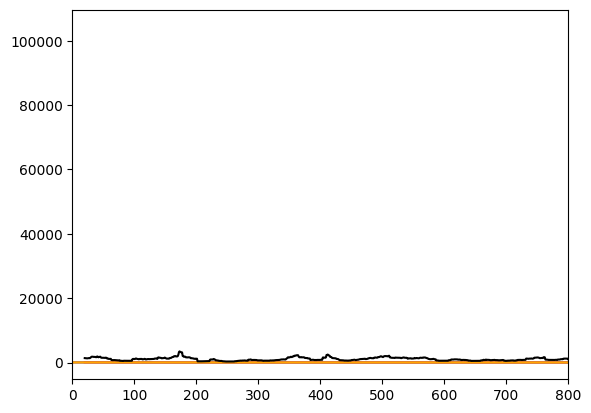

In [308]:
plt.plot(data["Close"])
plt.plot(data["AVG_P"], color = "red", alpha = 0.5)
#plt.plot(data["VW"] * data["AVG_P"].rolling(window = 20).sum(), color = "orange")

#plt.plot(data["Returns"] - data["Returns_c"]) # noise
#plt.plot(data["ROC20"] - data["ROC20C"], color = "blue", alpha = 0.5) # noise

price_denoised = data["Close"]* (1+(((data["ROC20"] - data["ROC20C"]) + (data["Returns"] - data["Returns_c"]))/2))#?
plt.plot(price_denoised, color = "red", alpha = 0.5)
#plt.plot(data["MA20"] - data["MAC20"], color = "red", alpha = 0.5)
plt.plot(data["trend"], color = "orange")
plt.plot(data["signal"], color = "black")
plt.xlim(0,800)
#plt.ylim(0, 30)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt  # PyWavelets for Wavelet transform
from pykalman import KalmanFilter

# ==========================================
# 1. Generate Synthetic Data (Dynamical System)
# ==========================================
np.random.seed(42)
n_timesteps = 200

# Generate a "True" hidden trend (e.g., a random walk)
true_trend = np.linspace(100, 130, n_timesteps) + np.sin(np.linspace(0, 10, n_timesteps)) * 5

# Add noise to simulate market microstructure/measurement noise
noise = np.random.normal(0, 2.5, n_timesteps)
observed_price = true_trend + noise

# Create a DataFrame
df = pd.DataFrame({'Close': observed_price})

# ==========================================
# 2. Kalman Filter (State-Space Approach)
# ==========================================
def apply_kalman_smoothing(data, transition_covariance=0.01, observation_covariance=1.0):
    """
    Applies a Kalman Smoother to the data.
    
    params:
    - transition_covariance: How much the actual system evolves (Process Noise).
      Lower = smoother trend (assumes system changes slowly).
    - observation_covariance: How much noise is in the data (Measurement Noise).
      Higher = smoother trend (trusts data less).
    """
    kf = KalmanFilter(
        transition_matrices=[1],          # State transition (Identity: x_t = x_{t-1})
        observation_matrices=[1],         # Observation matrix (z_t = x_t)
        initial_state_mean=data[0],       # Start at first price
        initial_state_covariance=1,       # Initial uncertainty
        observation_covariance=observation_covariance, 
        transition_covariance=transition_covariance
    )
    
    # Use .smooth() for offline processing (uses future data to refine past estimates)
    # Use .filter() for real-time online processing
    state_means, _ = kf.smooth(data)
    return state_means.flatten()

# Apply Kalman
df['Kalman_Trend'] = apply_kalman_smoothing(df['Close'].values)

# ==========================================
# 3. Wavelet Transform (Frequency Domain)
# ==========================================
def apply_wavelet_denoising(data, wavelet='db4', level=2):
    """
    Decomposes signal, thresholds the 'details' (noise), and reconstructs.
    """
    # 1. Decompose the signal
    coeffs = pywt.wavedec(data, wavelet, mode='per', level=level)
    
    # 2. Calculate a threshold (Universal Threshold method approx)
    # We estimate noise variance (sigma) from the finest detail coefficients
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))
    
    # 3. Apply Soft Thresholding to Detail Coefficients (indices 1 to end)
    # We generally keep the Approximation coefficients (index 0) untouched
    new_coeffs = list(coeffs)
    for i in range(1, len(coeffs)):
        new_coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
        
    # 4. Reconstruct the signal
    return pywt.waverec(new_coeffs, wavelet, mode='per')

# Apply Wavelet (Handling length mismatches if any)
denoised_wavelet = apply_wavelet_denoising(df['Close'].values)
# Ensure length matches (sometimes wavelets pad data)
df['Wavelet_Denoised'] = denoised_wavelet[:len(df)]

# ==========================================
# 4. Visualization
# ==========================================
plt.figure(figsize=(14, 7))

# Plot Raw Data
plt.plot(df['Close'], color='lightgray', label='Noisy Observation (Close)', linewidth=1.5)
plt.plot(true_trend, color='black', linestyle='--', alpha=0.6, label='True Hidden System')

# Plot Kalman
plt.plot(df['Kalman_Trend'], color='blue', label='Kalman Smoother (Trend)', linewidth=2)

# Plot Wavelet
plt.plot(df['Wavelet_Denoised'], color='red', label='Wavelet Denoising (Feature Preserving)', linewidth=1.5, alpha=0.9)

plt.title('Denoising Financial Dynamical Systems: Kalman vs. Wavelet')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [155]:
signal = []
b_t = False
t = 0
for i in range(len(data)):
    s = 0
    #buy
    if data["close"][i] < data["MA20"][i] and data["close"][i] < data["MA63"][i] and data["close"][i] < data["MA126"][i]:
        if data["MA20"][i] < data["MA63"][i] and data["MA63"][i] < data["MA126"][i]:
            s = 1
    
    # sell
    if data["close"][i] > data["MA20"][i] and data["close"][i] > data["MA63"][i] and data["close"][i] > data["MA126"][i]:
        if data["MA20"][i] > data["MA63"][i] and data["MA63"][i] > data["MA126"][i]:
            s = -1

    signal.append(s)

data["Signal"] = signal


data["sig"] = (data["ROC63"] > 0).astype(int)   # 1 long, 0 cash
data["signal_"] = (data["Close"] > data["MA63"]).astype(int)


data["mom_z"] = data["ROC63"] / (data["vol20"] * (63**0.5) + 1e-12)  # rough scaling

threshold = 0.5  # try 0.0, 0.2, 0.5
data["_signal"] = (data["mom_z"] > threshold).astype(int)

pos = data["_signal"].fillna(0).astype(int)  # 0/1 position
data["trade_signal"] = pos.diff().fillna(0)

# trade_signal: +1 on entry, -1 on exit, 0 otherwise
data["trade_signal"] = data["trade_signal"].clip(-1, 1)


(10.0, 25.0)

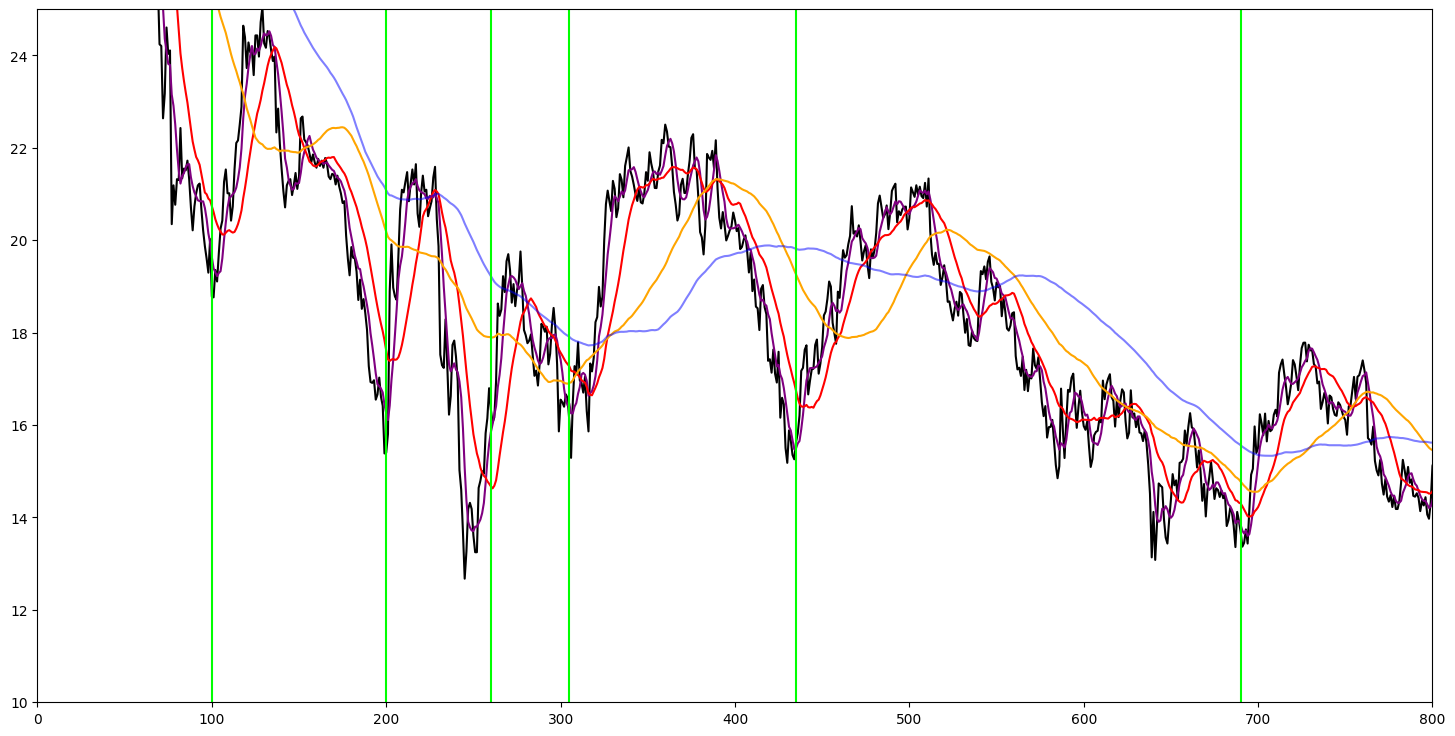

In [126]:
fig, ax = plt.subplots(figsize=(18, 9)) 

#plt.plot(data["Signal"])
#plt.plot(data["Signal2"], alpha = 0.5)
plt.plot(data["Close"], color = "black")
plt.plot(data["MA6"], color = "purple")
plt.plot(data["MA20"], color = "red")
plt.plot(data["MA63"], color = "orange")
plt.plot(data["MA126"], color = "blue", alpha = 0.5)
#plt.plot(data["MA200"])
#plt.plot(np.sign(data["ROC20"]))
#plt.plot(data["ROC126"])
#plt.plot(data["ROC200"])
plt.axvline(x=100, color="lime") # correct
#plt.axvline(x=135, color="red") # correct
plt.axvline(x=260, color="lime") # correct
plt.axvline(x=200, color="lime") # correct
#plt.axvline(x=225, color="red") # correct
plt.axvline(x=305, color="lime") # correct
#plt.axvline(x=335, color="red") # correct
plt.axvline(x=435, color="lime") # correct
#plt.axvline(x=500, color="red") # correct
plt.axvline(x=690, color="lime") # correct
#plt.axvline(x=728, color="red") # correct
#plt.plot(bt["equity"])
plt.xlim(0,800)
plt.ylim(10,25)

In [190]:
# buy
# R20 < 0 rolling linear regresion 20
# RS20 < 0 rolling sum of returns 20
data["ROC63"].rolling(window = 21).mean() < 0
m2 = (data["MA20"] - data["MA63"])/data["MA20"]
# close > MA6 > MA20 > MA63 > MA126...




# sell

# close <-> MA6
# close <-> MA20
# close < MA6 < MA20 < MA63 < MA126...


(0.0, 3.0)

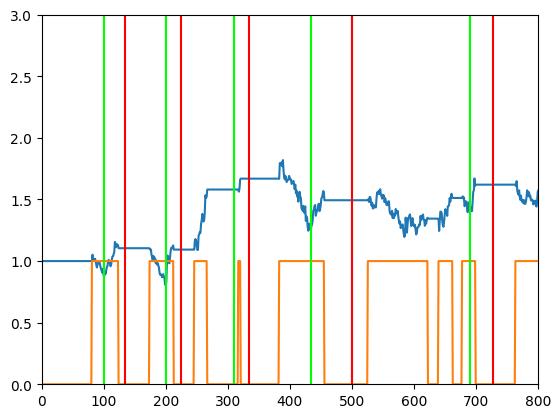

In [202]:
plt.plot(bt["equity"])
plt.plot(bt["position"])
plt.xlim(0,800)
plt.axvline(x=100, color="lime") # correct
plt.axvline(x=135, color="red") # correct
plt.axvline(x=200, color="lime") # correct
plt.axvline(x=225, color="red") # correct
plt.axvline(x=310, color="lime") # correct
plt.axvline(x=335, color="red") # correct
plt.axvline(x=435, color="lime") # correct
plt.axvline(x=500, color="red") # correct
plt.axvline(x=690, color="lime") # correct
plt.axvline(x=728, color="red") # correct
plt.ylim(0,3)

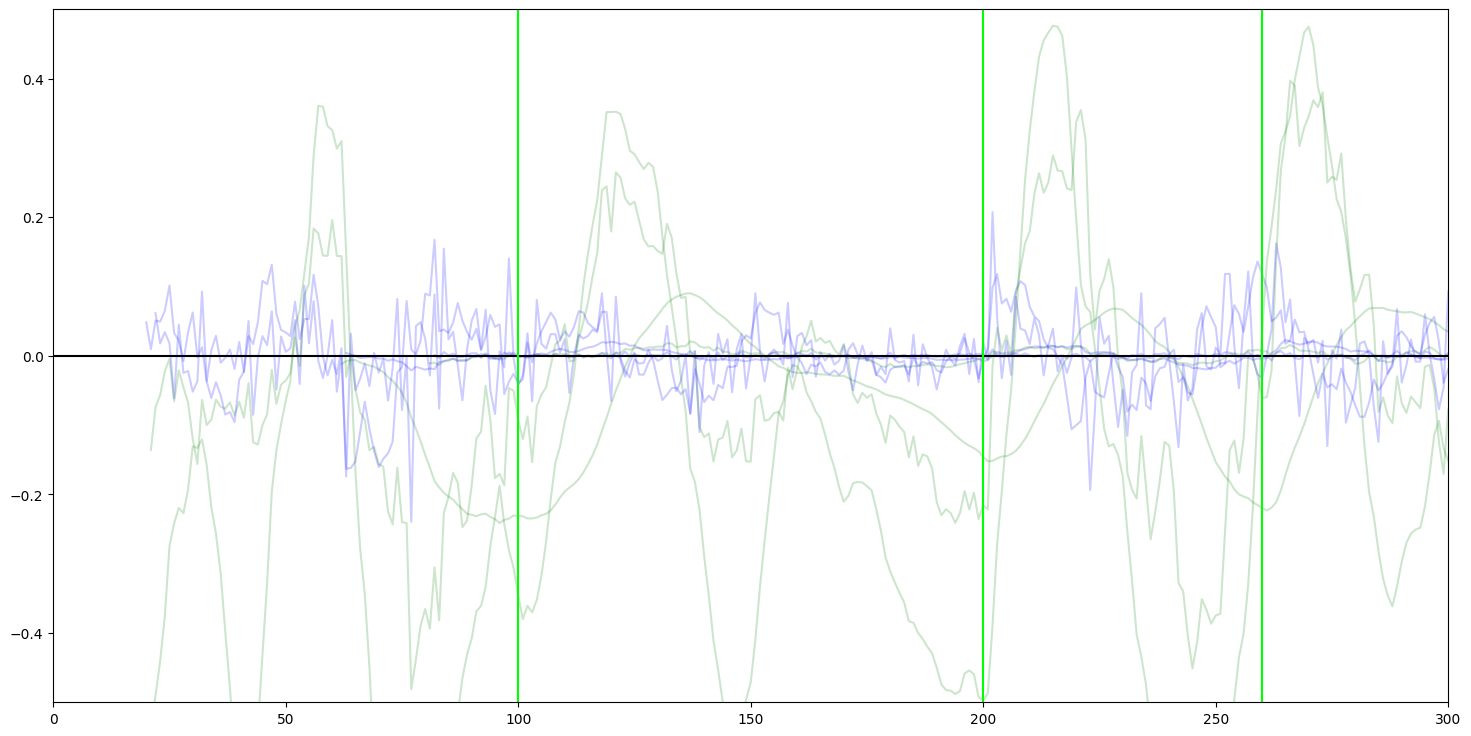

In [187]:
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(figsize=(18, 9))

roc_z = ((data["ROC20"] - data["ROC20"].rolling(window = 20).mean()) + (data["ROC63"] - data["ROC63"].rolling(window = 21).mean()))/2    #/data["ROC63"].rolling(window = 21).std()
#plt.plot(data["Signal"]/4, color = "black")
m1 = (data["MA6"] - data["Close"])/data["MA6"]
m2 = (data["MA20"] - data["MA63"])/data["MA20"]
m3 = (data["MA63"] - data["MA126"])/data["MA63"]
m4 = (data["MA20"] - data["MA126"])/data["MA20"]
#plt.plot(data["ROC63"].rolling(30).mean() - data["ROC63"].rolling(30).std(), color = "orange")
#plt.plot(m1, color = "red", alpha = 0.2)


#plt.plot(m4, color = "red", alpha = 0.2)

#plt.plot(roc_z, color = "blue", alpha = 0.2)

data["RS"] = data["Returns"].rolling(21).sum()
data["MS"] = m2
data["ROC"] = data["ROC63"].rolling(window = 21).mean().diff()
features = ["RS", "MS", "R20", "ROC"]
#data[features] = StandardScaler().fit_transform(data[features])
data["trend_score"] = data[features].mean(axis=1)
data["trend_smooth"] = data["trend_score"].ewm(span=10).mean()
data["trend_d"] = data["trend_score"].diff()
data["trend_dd"] = data["trend_d"].diff()

data["R20_d"] = data["R20"].diff()
data["RS_d"] = data["RS"].diff()
data["MS_d"] = data["MS"] .diff()
data["ROC_d"] = data["ROC"].diff()


plt.plot(data["R20"], color = "green", alpha = 0.2) # buy < 0
plt.plot(data["RS"], color = "green", alpha = 0.2) # buy < 0
plt.plot(data["MS"] , color = "green", alpha = 0.2) # buy < 0
plt.plot(data["ROC"], color = "green", alpha = 0.2) # buy < 0

plt.plot(data["R20_d"], color = "blue", alpha = 0.2) # buy < 0
plt.plot(data["RS_d"], color = "blue", alpha = 0.2) # buy < 0
plt.plot(data["MS_d"], color = "blue", alpha = 0.2) # buy < 0
plt.plot(data["ROC_d"], color = "blue", alpha = 0.2) # buy < 0




plt.axhline(y=0, color="black")
plt.axvline(x=100, color="lime") # correct
#plt.axvline(x=135, color="red") # correct
plt.axvline(x=260, color="lime") # correct
plt.axvline(x=200, color="lime") # correct
#plt.axvline(x=225, color="red") # correct
plt.axvline(x=320, color="lime") # correct
#plt.axvline(x=335, color="red") # correct
plt.axvline(x=435, color="lime") # correct
#plt.axvline(x=500, color="red") # correct
plt.axvline(x=690, color="lime") # correct
#plt.axvline(x=728, color="red") # correct
plt.xlim(0,300)
plt.ylim(-0.5,0.5)
plt.show()

In [ ]:
slope < 0
slope_d > 0
slope_dd > 0

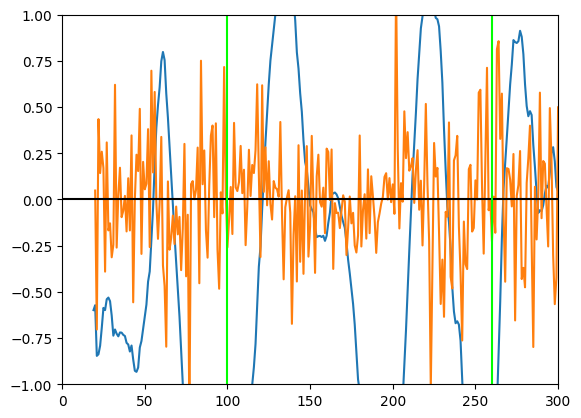

In [180]:


plt.plot(data["trend_smooth"], alpha = 1) # buy < 0
plt.plot(data["trend_d"], alpha = 1) # buy > 0
plt.plot(data["trend_dd"], alpha = 0.2) # buy > 0
plt.xlim(0,300)
plt.ylim(-1,1)
plt.axhline(y=0, color="black")
plt.axvline(x=100, color="lime") # correct
#plt.axvline(x=135, color="red") # correct
plt.axvline(x=260, color="lime") # correct
plt.show()

In [200]:
# +1 = buy, -1 = sell

bt = backtest_long_only_from_signal(data, price_col="Close", signal_col="Signal", fee=0.001)
initial_capital = 10_000  # set this to whatever you want

final_equity = bt["equity"].iloc[-1]          # e.g. 1.23 means +23%
total_return_pct = (final_equity - 1) * 100

final_value = initial_capital * final_equity
profit_money = final_value - initial_capital

print(f"Total return: {total_return_pct:.2f}%")
print(f"Final value:  {final_value:,.2f}")
print(f"Profit:       {profit_money:,.2f}")
# Max drawdown
eq = bt["equity"]
drawdown = eq / eq.cummax() - 1
max_dd_pct = drawdown.min() * 100
print(f"Max drawdown: {max_dd_pct:.2f}%")

# Number of round-trip trades (buy+sell)
round_trips = int(bt["position"].diff().abs().sum() / 2)
print(f"Round trips:  {round_trips}")


Total return: 419.67%
Final value:  51,966.82
Profit:       41,966.82
Max drawdown: -49.98%
Round trips:  62


In [90]:
import numpy as np

rf = 0.02        # 2% risk-free (annual)
periods = 252    # trading days

excess = bt["strat_ret"] - rf/periods

sharpe = np.sqrt(periods) * excess.mean() / excess.std()

print(f"Sharpe: {sharpe:.2f}")


Sharpe: 0.23


In [ ]:



df["roc20"] = df["close"].pct_change(20)
df["roc60"] = df["close"].pct_change(60)

df["vol20"] = df["close"].pct_change().rolling(20).std() * np.sqrt(252)
df["atr14"] = atr(df, 14)

# Trend strength proxy: EMA50 slope over ~1 month
df["ema50_slope"] = (df["ema50"] - df["ema50"].shift(20)) / df["ema50"].shift(20)

# Vol-adjusted momentum score
df["mom_score"] = (0.5 * df["roc20"] + 0.5 * df["roc60"]) / (df["vol20"] + 1e-12)


## RSI

## MACD

data["MA20"] = data["Close"].rolling(window = 20).mean()
data["MA_sign"] = np.sign(data["MA20"] - data["Close"]) 
data["Sign"] = np.sign(data["Returns"])
data["MA_signal"] = data["Close"] > data["Close"].rolling(window=200).mean()


# Risk 
data["vol"] = data["Returns"].rolling(window = 20).std()
data["ATR"] = atr(data, n = 14)

# Trend
data["T1"] = (data["Close"] / data["Close"].rolling(window = 200).mean()) - 1
#trend_i = (Close / SMA200) - 1
#trend_i = slope(50d linear regression of log price)
data["T2"] = rolling_linreg_slope(data["LogP"], window = 60)

# Momentum
data["mom_1m"] = (data["Close"] - data["Close"].shift(21))/data["Close"].shift(21)
data["mom_3m"] = (data["Close"] - data["Close"].shift(63))/data["Close"].shift(63)
data["mom_6m"] = (data["Close"] - data["Close"].shift(126))/data["Close"].shift(126)
data["mom_12m"] = (data["Close"] - data["Close"].shift(252))/data["Close"].shift(252)
data["mom"] = 0.4*z(data["mom_6m"]) + 0.3*z(data["mom_12m"]) + 0.2*z(data["mom_3m"]) - 0.1*z(data["mom_1m"])

# Overextension
data["Stretch"] = (data["Close"] - data["MA20"]) / data["ATR"]
#RSI14 > 70

data = data.reset_index(drop = True)

data["Z_mom"] = z(data["mom"])
data["Z_trend"] = z(0.5*data["T1"]+0.5*data["T2"])
data["Z_Stretch"] = z(data["Stretch"])

a = 0.6*data["Z_mom"][len(data)-1] + 0.4*data["Z_trend"][len(data)-1] - 0.3*data["Z_Stretch"][len(data)-1]  # + 0.2*z(p) if you have p
a = max(a,0)

r = (a ** 2) / (data["vol"][len(data)-1] ** 1)

In [37]:
df = yf.download("MSFT", start="2014-01-01", auto_adjust=True, progress=False)
df.columns = df.columns.droplevel(1)
df.columns = [c.lower() for c in df.columns]
df

,close,high,low,open,volume
Date,,,,,
2014-01-02,30.831133,31.030259,30.781351,30.988772,30632200
2014-01-03,30.623713,30.880916,30.366509,30.864322,31134800
2014-01-06,29.976562,30.607123,29.959968,30.573934,43603700
2014-01-07,30.208872,30.275248,30.042934,30.142499,35802800
2014-01-08,29.669563,29.984845,29.520223,29.868689,59971700
...,...,...,...,...,...
2026-02-02,423.369995,430.739990,422.250000,430.239990,42219900
2026-02-03,411.209991,422.049988,408.559998,422.010010,61424100
2026-02-04,414.190002,419.799988,409.239990,411.000000,45012400


In [318]:
import numpy as np
import pandas as pd
import yfinance as yf

def get_data(ticker: str, start="2014-01-01") -> pd.DataFrame:
    df = yf.download(ticker, start=start, auto_adjust=True, progress=False)
    df.columns = df.columns.droplevel(1)
    df.columns = [c.lower() for c in df.columns]
    return df.dropna()

def ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()

def atr(df: pd.DataFrame, n: int = 14) -> pd.Series:
    h, l, c = df["High"], df["Low"], df["Close"]
    tr = pd.concat([(h - l), (h - c.shift()).abs(), (l - c.shift()).abs()], axis=1).max(axis=1)
    return tr.rolling(n).mean()

def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["ema50"] = ema(df["close"], 50)
    df["ema200"] = ema(df["close"], 200)

    df["roc20"] = df["close"].pct_change(20)
    df["roc60"] = df["close"].pct_change(60)

    df["vol20"] = df["close"].pct_change().rolling(20).std() * np.sqrt(252)
    df["atr14"] = atr(df, 14)

    # Trend strength proxy: EMA50 slope over ~1 month
    df["ema50_slope"] = (df["ema50"] - df["ema50"].shift(20)) / df["ema50"].shift(20)

    # Vol-adjusted momentum score
    df["mom_score"] = (0.5 * df["roc20"] + 0.5 * df["roc60"]) / (df["vol20"] + 1e-12)
    return df

def make_signals(df: pd.DataFrame, min_mom=0.10, max_vol=0.60) -> pd.DataFrame:
    df = df.copy()
    trend_ok = (df["close"] > df["ema50"]) & (df["ema50"] > df["ema200"]) & (df["ema50_slope"] > 0)
    mom_ok = df["mom_score"] > min_mom
    vol_ok = df["vol20"] < max_vol

    df["entry"] = trend_ok & mom_ok & vol_ok
    df["exit"] = (df["close"] < df["ema50"])  # simple trend-break exit
    return df

def backtest_long_only(df: pd.DataFrame, fee=0.001, stop_atr=2.5) -> pd.DataFrame:
    """
    Long-only. When entry triggers: go long (position=1). Exit on trend break or ATR trailing stop.
    fee: per trade (e.g. 0.001 = 0.10%).
    """
    df = df.copy()
    pos = np.zeros(len(df), dtype=np.int8)
    in_pos = False
    stop = -np.inf

    for i in range(len(df)):
        c = float(df["close"].iloc[i])
        a = float(df["atr14"].iloc[i]) if np.isfinite(df["atr14"].iloc[i]) else np.nan

        if not in_pos:
            if bool(df["entry"].iloc[i]):
                in_pos = True
                pos[i] = 1
                if np.isfinite(a):
                    stop = c - stop_atr * a
        else:
            pos[i] = 1
            if np.isfinite(a):
                stop = max(stop, c - stop_atr * a)

            if bool(df["exit"].iloc[i]) or (c < stop):
                in_pos = False
                pos[i] = 0
                stop = -np.inf

    df["position"] = pos
    df["ret"] = df["close"].pct_change().fillna(0.0)
    df["strat_ret"] = df["position"].shift(1).fillna(0.0) * df["ret"]

    # Apply fees on position changes (enter/exit)
    trades = df["position"].diff().abs().fillna(0.0)
    df["strat_ret"] -= trades * fee

    df["equity"] = (1 + df["strat_ret"]).cumprod()
    return df

def stats(bt: pd.DataFrame) -> dict:
    eq = bt["equity"]
    total_return = float(eq.iloc[-1] - 1)
    dd = (eq / eq.cummax()) - 1
    max_dd = float(dd.min())
    round_trips = int(bt["position"].diff().abs().sum() / 2)
    return {"total_return": total_return, "max_drawdown": max_dd, "round_trips": round_trips}

# Optional: screen a universe and rank by momentum score (lets you pick “any stock”)
def screen_universe(tickers, start="2014-01-01") -> pd.DataFrame:
    rows = []
    for t in tickers:
        try:
            df = add_indicators(get_data(t, start=start)).dropna()
            last = df.iloc[-1]
            trend_ok = (last["close"] > last["ema50"]) and (last["ema50"] > last["ema200"]) and (last["ema50_slope"] > 0)
            rows.append({
                "ticker": t,
                "trend_ok": trend_ok,
                "mom_score": float(last["mom_score"]),
                "roc60": float(last["roc60"]),
                "vol20": float(last["vol20"]),
            })
        except Exception as e:
            rows.append({"ticker": t, "trend_ok": False, "mom_score": np.nan, "roc60": np.nan, "vol20": np.nan})

    out = pd.DataFrame(rows).sort_values(["trend_ok", "mom_score"], ascending=[False, False])
    return out.reset_index(drop=True)

if __name__ == "__main__":
    # 1) MSFT run
    df = get_data("MSFT", start="2014-01-01")
    df = add_indicators(df)
    df = make_signals(df, min_mom=0.10, max_vol=0.60)
    bt = backtest_long_only(df, fee=0.001, stop_atr=2.5)
    print("MSFT:", stats(bt))
    print(bt[["close","ema50","ema200","mom_score","position","equity"]].tail())

    # 2) Universe screening example (edit universe to your taste)
    universe = ["MSFT","AAPL","NVDA","AMZN","META","GOOGL","TSLA","AVGO","AMD","QQQ","SPY"]
    ranks = screen_universe(universe)
    print("\nTop candidates now:")
    print(ranks.head(10))


KeyError: 'High'

In [322]:
us_list = _list[_list["Exchange"] == " US"]
us_list = us_list.reset_index(drop = True)
us_list["alpha"] = 0
us_list["raw"] = 0
us_list["w"] = 0

#for i in range(len(us_list)):
for i in range(len(us_list)):
    data = yf.download(us_list["Symbol"][i], start="2000-01-01", end="2026-02-10")
    data.columns = data.columns.droplevel(1)
    data["Returns"] = data["Close"].diff() / data["Close"].shift(1)
    data["LogP"] = np.log(data["Close"])
    data["MA20"] = data["Close"].rolling(window = 20).mean()
    data["MA_sign"] = np.sign(data["MA20"] - data["Close"]) 
    data["Sign"] = np.sign(data["Returns"])
    data["MA_signal"] = data["Close"] > data["Close"].rolling(window=200).mean()


    # Risk 
    data["vol"] = data["Returns"].rolling(window = 20).std()
    data["ATR"] = atr(data, n = 14)

    # Trend
    data["T1"] = (data["Close"] / data["Close"].rolling(window = 200).mean()) - 1
    #trend_i = (Close / SMA200) - 1
    #trend_i = slope(50d linear regression of log price)
    data["T2"] = rolling_linreg_slope(data["LogP"], window = 60)

    # Momentum
    data["mom_1m"] = (data["Close"] - data["Close"].shift(21))/data["Close"].shift(21)
    data["mom_3m"] = (data["Close"] - data["Close"].shift(63))/data["Close"].shift(63)
    data["mom_6m"] = (data["Close"] - data["Close"].shift(126))/data["Close"].shift(126)
    data["mom_12m"] = (data["Close"] - data["Close"].shift(252))/data["Close"].shift(252)
    data["mom"] = 0.4*z(data["mom_6m"]) + 0.3*z(data["mom_12m"]) + 0.2*z(data["mom_3m"]) - 0.1*z(data["mom_1m"])
    
    # Overextension
    data["Stretch"] = (data["Close"] - data["MA20"]) / data["ATR"]
    #RSI14 > 70
    
    data = data.reset_index(drop = True)

    data["Z_mom"] = z(data["mom"])
    data["Z_trend"] = z(0.5*data["T1"]+0.5*data["T2"])
    data["Z_Stretch"] = z(data["Stretch"])

    a = 0.6*data["Z_mom"][len(data)-1] + 0.4*data["Z_trend"][len(data)-1] - 0.3*data["Z_Stretch"][len(data)-1]  # + 0.2*z(p) if you have p
    us_list["alpha"][i] = max(a,0)

    us_list["raw"][i] = (us_list["alpha"][i] ** 2) / (data["vol"][len(data)-1] ** 1)

for i in range(len(us_list)):
    us_list["w"][i] = us_list["raw"][i] / sum(us_list["raw"])
    us_list["w"][i] = min(0.6, us_list["w"][i])

    us_list["w"][i] = us_list["w"][i] / sum(us_list["w"])

us_list = us_list.sort_values(by="w", ascending=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [324]:
us_list

,Name,Symbol,Exchange,alpha,raw,w
0,3M Company,MMM,US,0.132152,0.667652,1.000000
1,Adobe Inc.,ADBE,US,0.000000,0.000000,0.375000
2,Advanced Micro Devices Inc.,AMD,US,0.510008,4.705381,0.303797
3,Airbnb Inc.,ABNB,US,0.386918,6.597854,0.263297
4,Alaska Air Group Inc,ALK,US,0.000000,0.000000,0.236026
5,Alphabet 2 Inc.,GOOG,US,2.108412,329.552758,0.215973
6,Amazon.com Inc.,AMZN,US,0.000000,0.000000,0.200395
7,American Airlines Group Inc.,AAL,US,0.302216,2.798905,0.187824
8,American Electric Power Group Inc.,AEP,US,0.276884,8.736935,0.177393
9,American Express Company,AXP,US,0.359293,7.539448,0.168553


In [323]:
us = us_list.head(3)
us = us.reset_index(drop = True)
us["w"][0] = 0.60
us["w"][1] = 0.23
us

,Name,Symbol,Exchange,alpha,raw,w
0,3M Company,MMM,US,0.132152,0.667652,0.600000
1,Adobe Inc.,ADBE,US,0.000000,0.000000,0.230000
2,Advanced Micro Devices Inc.,AMD,US,0.510008,4.705381,0.303797


### DK

In [350]:
DK_list = _list[_list["Exchange"] == " CO"]
DK_list = DK_list.reset_index(drop = True)
DK_list["alpha"] = 0
DK_list["raw"] = 0
DK_list["w"] = 0

#for i in range(len(us_list)):
for i in range(len(DK_list)-1):
    sym = DK_list["Symbol"][i]
    sym = sym[1:len(sym)-1]+ ".CO"
    data = yf.download(sym, start="2000-01-01", end="2026-02-10")
    data.columns = data.columns.droplevel(1)
    data["Returns"] = data["Close"].diff() / data["Close"].shift(1)
    data["LogP"] = np.log(data["Close"])
    data["MA20"] = data["Close"].rolling(window = 20).mean()
    data["MA_sign"] = np.sign(data["MA20"] - data["Close"]) 
    data["Sign"] = np.sign(data["Returns"])
    data["MA_signal"] = data["Close"] > data["Close"].rolling(window=200).mean()


    # Risk 
    data["vol"] = data["Returns"].rolling(window = 20).std()
    data["ATR"] = atr(data, n = 14)

    # Trend
    data["T1"] = (data["Close"] / data["Close"].rolling(window = 200).mean()) - 1
    #trend_i = (Close / SMA200) - 1
    #trend_i = slope(50d linear regression of log price)
    data["T2"] = rolling_linreg_slope(data["LogP"], window = 60)

    # Momentum
    data["mom"] = (data["Close"] - data["Close"].shift(126))/data["Close"].shift(126)
    
    # Overextension
    data["Stretch"] = (data["Close"] - data["MA20"]) / data["ATR"]
    #RSI14 > 70
    
    data = data.reset_index(drop = True)

    data["Z_mom"] = z(data["mom"])
    data["Z_trend"] = z(0.5*data["T1"]+0.5*data["T2"])
    data["Z_Stretch"] = (data["Stretch"]-data["Stretch"].rolling(window = 20).mean())/data["Stretch"].rolling(window=20).std()

    a = 0.6*data["Z_mom"][len(data)-1] + 0.4*data["Z_trend"][len(data)-1] - 0.3*data["Z_Stretch"][len(data)-1]  # + 0.2*z(p) if you have p
    DK_list["alpha"][i] = max(a,0)

    DK_list["raw"][i] = (DK_list["alpha"][i] ** 2) / (data["vol"][len(data)-1] ** 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [351]:
a

np.float64(-0.8973027154305016)

In [348]:
DK_list

,Name,Symbol,Exchange,alpha,raw,w
0,A.P.Møller - Mærsk B,MAERSK-B,CO,0.479107,10.151232,0
1,ALK-Abelló B,ALK-B,CO,0.117743,0.879148,0
2,Alm. Brand,ALMB,CO,0.014147,0.014524,0
3,Ambu,AMBU-B,CO,0.000000,0.000000,0
4,Aquaporin,AQP,CO,0.000000,0.000000,0
5,Bang & Olufsen,BO,CO,0.000000,0.000000,0
6,Bavarian Nordic,BAVA,CO,0.000000,0.000000,0
7,BioPorto,BIOPOR,CO,0.000000,0.000000,0
8,Brdr. A & O Johansen B,AOJ-B,CO,0.000000,0.000000,0
9,Carlsberg B,CARL-B,CO,0.077409,0.390512,0


In [341]:
for i in range(len(DK_list)):
    DK_list["w"][i] = DK_list["raw"][i] / sum(DK_list["raw"])
    DK_list["w"][i] = min(0.6, DK_list["w"][i])

    DK_list["w"][i] = DK_list["w"][i] / sum(DK_list["w"])

DK_list = DK_list.sort_values(by="w", ascending=False)

DK = DK_list.head(3)
DK = DK.reset_index(drop = True)
DK["w"][0] = 0.60
#us["w"][1] = 0.23
DK

,Name,Symbol,Exchange,alpha,raw,w
0,BioPorto,BIOPOR,CO,NaN,NaN,0.600000
1,Brdr. A & O Johansen B,AOJ-B,CO,NaN,NaN,0.177609
2,Carlsberg B,CARL-B,CO,NaN,NaN,0.177134


### SWE

In [353]:
SWE_list = _list[_list["Exchange"] == " ST"]
SWE_list = SWE_list.reset_index(drop = True)
SWE_list["alpha"] = 0
SWE_list["raw"] = 0
SWE_list["w"] = 0

#for i in range(len(us_list)):
for i in range(len(SWE_list)):
    sym = SWE_list["Symbol"][i]
    sym = sym[1:len(sym)-1]+ ".ST"
    data = yf.download(sym, start="2000-01-01", end="2026-02-10")
    data.columns = data.columns.droplevel(1)
    data["Returns"] = data["Close"].diff() / data["Close"].shift(1)
    data["LogP"] = np.log(data["Close"])
    data["MA20"] = data["Close"].rolling(window = 20).mean()
    data["MA_sign"] = np.sign(data["MA20"] - data["Close"]) 
    data["Sign"] = np.sign(data["Returns"])
    data["MA_signal"] = data["Close"] > data["Close"].rolling(window=200).mean()


    # Risk 
    data["vol"] = data["Returns"].rolling(window = 20).std()
    data["ATR"] = atr(data, n = 14)

    # Trend
    data["T1"] = (data["Close"] / data["Close"].rolling(window = 200).mean()) - 1
    #trend_i = (Close / SMA200) - 1
    #trend_i = slope(50d linear regression of log price)
    data["T2"] = rolling_linreg_slope(data["LogP"], window = 60)

    # Momentum
    data["mom"] = (data["Close"] - data["Close"].shift(126))/data["Close"].shift(126)
    
    # Overextension
    data["Stretch"] = (data["Close"] - data["MA20"]) / data["ATR"]
    #RSI14 > 70
    
    data = data.reset_index(drop = True)

    data["Z_mom"] = z(data["mom"])
    data["Z_trend"] = z(0.5*data["T1"]+0.5*data["T2"])
    data["Z_Stretch"] = (data["Stretch"]-data["Stretch"].rolling(window = 20).mean())/data["Stretch"].rolling(window=20).std()

    a = 0.6*data["Z_mom"][len(data)-1] + 0.4*data["Z_trend"][len(data)-1] - 0.3*data["Z_Stretch"][len(data)-1]  # + 0.2*z(p) if you have p
    SWE_list["alpha"][i] = max(a,0)

    SWE_list["raw"][i] = (SWE_list["alpha"][i] ** 2) / (data["vol"][len(data)-1] ** 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [352]:
for i in range(len(SWE_list)):
    SWE_list["w"][i] = SWE_list["raw"][i] / sum(SWE_list["raw"])
    SWE_list["w"][i] = min(0.6, SWE_list["w"][i])

    #SWE_list["w"][i] = SWE_list["w"][i] / sum(SWE_list["w"])

SWE_list = SWE_list.sort_values(by="w", ascending=False)

SWE = SWE_list.head(3)
SWE = SWE.reset_index(drop = True)
#us["w"][0] = 0.60
#us["w"][1] = 0.23
SWE_list

,Name,Symbol,Exchange,alpha,raw,w
0,AAK AB,AAK,ST,0.000000,0.000000,0.6
1,ABB Ltd,ABB,ST,NaN,NaN,0.6
2,AcadeMedia AB,ACAD,ST,0.209742,3.054915,0.6
3,Acrinova AB Ser. A,ACRI-A,ST,NaN,NaN,0.6
4,Acrinova AB Ser. B,ACRI-B,ST,0.000000,0.000000,0.6
...,...,...,...,...,...,...
74,Duni AB,DUNI,ST,0.530249,14.668136,0.6
75,Dustin Group AB,DUST,ST,0.229956,1.457744,0.6
76,Dynavox Group AB,DYVOX,ST,0.000000,0.000000,0.6
77,Eastnine AB,EAST,ST,NaN,NaN,0.6


### NO

In [339]:
NO_list = _list[_list["Exchange"] == " OL"]
NO_list = NO_list.reset_index(drop = True)
NO_list["alpha"] = 0
NO_list["raw"] = 0
NO_list["w"] = 0

#for i in range(len(us_list)):
for i in range(len(NO_list)):
    sym = NO_list["Symbol"][i]
    sym = sym[1:len(sym)-1]+ ".OL"
    data = yf.download(sym, start="2000-01-01", end="2026-02-10")
    data.columns = data.columns.droplevel(1)
    data["Returns"] = data["Close"].diff() / data["Close"].shift(1)
    data["LogP"] = np.log(data["Close"])
    data["MA20"] = data["Close"].rolling(window = 20).mean()
    data["MA_sign"] = np.sign(data["MA20"] - data["Close"]) 
    data["Sign"] = np.sign(data["Returns"])
    data["MA_signal"] = data["Close"] > data["Close"].rolling(window=200).mean()


    # Risk 
    data["vol"] = data["Returns"].rolling(window = 20).std()
    data["ATR"] = atr(data, n = 14)

    # Trend
    data["T1"] = (data["Close"] / data["Close"].rolling(window = 200).mean()) - 1
    #trend_i = (Close / SMA200) - 1
    #trend_i = slope(50d linear regression of log price)
    data["T2"] = rolling_linreg_slope(data["LogP"], window = 60)

    # Momentum
    data["mom"] = (data["Close"] - data["Close"].shift(126))/data["Close"].shift(126)
    
    # Overextension
    data["Stretch"] = (data["Close"] - data["MA20"]) / data["ATR"]
    #RSI14 > 70
    
    data = data.reset_index(drop = True)

    data["Z_mom"] = z(data["mom"])
    data["Z_trend"] = z(0.5*data["T1"]+0.5*data["T2"])
    data["Z_Stretch"] = z(data["Stretch"])

    a = 0.6*data["Z_mom"][len(data)-1] + 0.4*data["Z_trend"][len(data)-1] - 0.3*data["Z_Stretch"][len(data)-1]  # + 0.2*z(p) if you have p
    NO_list["alpha"][i] = max(a,0)

    NO_list["raw"][i] = (NO_list["alpha"][i] ** 2) / (data["vol"][len(data)-1] ** 1)

for i in range(len(NO_list)):
    NO_list["w"][i] = NO_list["raw"][i] / sum(NO_list["raw"])
    NO_list["w"][i] = min(0.6, NO_list["w"][i])

    NO_list["w"][i] = NO_list["w"][i] / sum(NO_list["w"])

NO_list = NO_list.sort_values(by="w", ascending=False)

NO = NO_list.head(3)
NO = NO.reset_index(drop = True)
NO["w"][0] = 0.60
#us["w"][1] = 0.23
NO_list

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Name,Symbol,Exchange,alpha,raw,w
0,2020 BULKERS,2020,OL,0.168230,2.174715,1.000000
1,ABG SUNDAL COLLIER HOLDING,ABG,OL,0.055140,0.355975,0.375000
2,ABL GROUP ASA,ABL,OL,0.000000,0.000000,0.303797
3,AF GRUPPEN,AFG,OL,NaN,NaN,0.263297
4,AGILYX ASA,AGLX,OL,0.000000,0.000000,0.236026
5,AIRTHINGS,AIRX,OL,0.000000,0.000000,0.215973
6,AKASTOR,AKAST,OL,0.000000,0.000000,0.200395
7,AKER,AKER,OL,0.000000,0.000000,0.187824
8,AKER BIOMARINE ASA,AKBM,OL,0.672245,25.336327,0.177393
9,AKER BP,AKRBP,OL,0.161226,1.269933,0.168553


### FI

In [335]:
he_list = _list[_list["Exchange"] == " HE"]
he_list = he_list.reset_index(drop = True)
he_list["alpha"] = 0
he_list["raw"] = 0
he_list["w"] = 0

#for i in range(len(us_list)):
for i in range(len(he_list)):
    sym = he_list["Symbol"][i]
    sym = sym[1:len(sym)-1]+ ".HE"
    data = yf.download(sym, start="2000-01-01", end="2026-02-10")
    data.columns = data.columns.droplevel(1)
    data["Returns"] = data["Close"].diff() / data["Close"].shift(1)
    data["LogP"] = np.log(data["Close"])
    data["MA20"] = data["Close"].rolling(window = 20).mean()
    data["MA_sign"] = np.sign(data["MA20"] - data["Close"]) 
    data["Sign"] = np.sign(data["Returns"])
    data["MA_signal"] = data["Close"] > data["Close"].rolling(window=200).mean()


    # Risk 
    data["vol"] = data["Returns"].rolling(window = 20).std()
    data["ATR"] = atr(data, n = 14)

    # Trend
    data["T1"] = (data["Close"] / data["Close"].rolling(window = 200).mean()) - 1
    #trend_i = (Close / SMA200) - 1
    #trend_i = slope(50d linear regression of log price)
    data["T2"] = rolling_linreg_slope(data["LogP"], window = 60)

    # Momentum
    data["mom"] = (data["Close"] - data["Close"].shift(126))/data["Close"].shift(126)
    
    # Overextension
    data["Stretch"] = (data["Close"] - data["MA20"]) / data["ATR"]
    #RSI14 > 70
    
    data = data.reset_index(drop = True)

    data["Z_mom"] = z(data["mom"])
    data["Z_trend"] = z(0.5*data["T1"]+0.5*data["T2"])
    data["Z_Stretch"] = z(data["Stretch"])

    a = 0.6*data["Z_mom"][len(data)-1] + 0.4*data["Z_trend"][len(data)-1] - 0.3*data["Z_Stretch"][len(data)-1]  # + 0.2*z(p) if you have p
    he_list["alpha"][i] = max(a,0)

    he_list["raw"][i] = (he_list["alpha"][i] ** 2) / (data["vol"][len(data)-1] ** 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [338]:
for i in range(len(he_list)):
    he_list["w"][i] = he_list["raw"][i] / sum(he_list["raw"])
    he_list["w"][i] = min(0.6, he_list["w"][i])

    #he_list["w"][i] = us_list["w"][i] / sum(us_list["w"])

he_list = he_list.sort_values(by="w", ascending=False)

he = he_list.head(3)
he = he.reset_index(drop = True)
#us["w"][0] = 0.60
#us["w"][1] = 0.23
he_list

,Name,Symbol,Exchange,alpha,raw,w
0,Aktia Pankki Oyj,AKTIA,HE,1.468286,146.268335,0.600000
1,AS Tallink Grupp FDR,TALLINK,HE,0.486509,13.380304,0.081818
2,CapMan,CAPMAN,HE,0.192468,3.538756,0.021639
3,Citycon Oyj,CTY1S,HE,0.029157,0.350948,0.002146
